# Introduction

In this benchmarking challenge, you will be tasked to create an [AutoRA theorist](https://autoresearch.github.io/autora/theorist/) to discover equations that best describe a given data set.

You can use this notebook to benchmark your theorist based on 3 different datasets from 3 different cogntive models, respectively.








## Benchmarking Challenge Rules

- All contributing teams must publish a pip package of their theorist. We recommend using a pre-release.
- The package name must be ``autora-theorist-yourtheorist``
- The **theorist must have a fit and predict function**, and it must be **compatible with the synthetic models** in this notebook. We will call the following code to evaluate the theorists, except that we won't be using the Weber-Fechner-Law:

```python
pip install --pre <autora-theorist-yourtheorist>

from autora.theorist.yourtheorist import yourtheorist
from autora.experiment_runner.synthetic.psychophysics.weber_fechner_law import weber_fechner_law # this will be a secret ground truth model

experiment_runner = weber_fechner_law()
theorist = yourtheorist()

# generate all conditions
conditions = experiment_runner.domain()

# generate all corresponding observations
experiment_data = experiment_runner.run(conditions, added_noise=0.01)

# get the name of the independent and independent variables
ivs = [iv.name for iv in experiment_runner.variables.independent_variables]
dvs = [dv.name for dv in experiment_runner.variables.dependent_variables]

# extract the dependent variable (observations) from experiment data
conditions = experiment_data[ivs]
observations = experiment_data[dvs]

# split into train and test datasets
conditions_train, conditions_test, observations_train, observations_test = train_test_split(conditions, observations)

# fit theorist
theorist.fit(conditions_train, observations_train)

# compute prediction for validation set
predictions = theorist.predict(conditions_test)

# evaluate theorist performance
error = (predictions - observations_test).pow(2)
error = error.mean()

theorist.print_eqn()


```

- Theorist also **must have a function ``print_eqn`` returning the discovered equation as a string.**
- The discovered equation **may not include more than 40 symbols/function elements**.
- Teams will be ranked based on the fit to two ground-truth models. Observations will be sampled across the entire domain of the ground-truth model. The rank will be accumulated across all benchmarking challenges. The team with the best accumulated rank will win a prize at the end of the workshop.
- The teams must provide a **brief presentation** (less than 5 minutes) of their theorist just before the final evaluation. You may use [this template for your slides](https://docs.google.com/presentation/d/1esmYO09ehiGOkzBsBAEf_wCfx2JrlmWwP7dyfpu0dEM/edit?usp=sharing).

*Hint: You may not use a search space including more than the following functions and operators.*
  - +
  - -
  - *
  - /
  - e^x
  - ln x
  - x^c
  - c (constants may appear)

## Grading

- Due date: **August 30**
- Submission: Through ``Stud.IP -> Tasks -> Equation Discovery Challenge``

The grading is independent of the outcome of the benchmarking challenge.

The following points will be provided:
- A demonstration of the theorist in the ``doc/Basic Usage.ipynb``:
  -  2 points: Demonstrating how to use the theorist for fitting
  -  2 points: Demonstrating how to use the theorist for predicting
  -  2 points: Demonstrating how to obtain the equation fit by the theorist
  -  4 points: Demonstrating that the theorist can recover at least two ground truth models. (*Hint: You could use the benchmarking part of the notebook below as a starting point*).
- The documentation of the theorist in ``doc/index.md`` must speak to the following information:
  - 2 points: Search Algorithm: a description of the search algorithm, and how the goodness of the equation was determined?
  - 2 points: Search Space: which search space was used and how was the search otherwise constrained?
- 2 points: The code contains at least two useful unit tests for the theorist method (either doc tests or separate tests)
- 1 point: the contributors used issues to track bugs and work on features.
- 1 point: the contributors used (helpful) code reviews for their PRs.
- 1 point: Unit tests are automatically executed when a pull request is created.
- 1 point: The documentation is hosted automatically.

Finally, teams must outline the contributions of each team member in their submission on ``Stud.IP -> Tasks -> Equation Discovery Challenge``.

In total, you can obtain 20 points.

## Additional Resources

- You can learn more about how to write AutoRA theorists in the [Contributor Guide](https://autoresearch.github.io/autora/contribute/modules/theorist/).

- You can learn more about how to use AutoRA in the [User Tutorial](https://autoresearch.github.io/autora/tutorials/).

- If you want to learn more about AutoRA states, you can check out [this tutorial on using AutoRA states](https://colab.research.google.com/drive/1yK1OBRpPZM1NgTMV9arHlE5j8xXjsGqq?usp=sharing).

# Code for Benchmarking your Theorist

## Installation

*Hint: You may want to add ``autora`` as a development dependency in your ``pyproject.tml``.*

In [114]:
%%capture
!pip install autora
!pip install autora[all-theorists]

## Imports

In [138]:
# autora state
from autora.state import StandardState, on_state, Delta

# experiment_runner
from autora.experiment_runner.synthetic.psychophysics.weber_fechner_law import weber_fechner_law
from autora.experiment_runner.synthetic.psychophysics.stevens_power_law import stevens_power_law
from autora.experiment_runner.synthetic.economics.expected_value_theory import expected_value_theory
from autora.experiment_runner.synthetic.psychology.luce_choice_ratio import luce_choice_ratio
from autora.experiment_runner.synthetic.psychology.q_learning import q_learning
from autora.experiment_runner.synthetic.psychology.exp_learning import exp_learning
from autora.experiment_runner.synthetic.economics.expected_value_theory import expected_value_theory
from autora.experiment_runner.synthetic.economics.prospect_theory import prospect_theory
from autora.experiment_runner.synthetic.abstract.lmm import lmm_experiment
from autora.experiment_runner.synthetic.abstract.template_experiment import template_experiment
from autora.experiment_runner.synthetic.neuroscience.task_switching import task_switching


# experimentalist
from autora.experimentalist.grid import grid_pool
from autora.experimentalist.random import random_pool, random_sample

# data handling
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


## Benchmarking Function

We will use the following function for benchmarking our model for any given experiment runner.

In [130]:
def benchmark(experiment_runner, theorist):

  # generate all conditions
  conditions = experiment_runner.domain()

  # generate all corresponding observations
  experiment_data = experiment_runner.run(conditions, added_noise=0.01)

  # get the name of the independent and independent variables
  ivs = [iv.name for iv in experiment_runner.variables.independent_variables]
  dvs = [dv.name for dv in experiment_runner.variables.dependent_variables]

  # extract the dependent variable (observations) from experiment data
  conditions = experiment_data[ivs]
  observations = experiment_data[dvs]

  # split into train and test datasets
  conditions_train, conditions_test, observations_train, observations_test = train_test_split(conditions, observations)

  print("#### EXPERIMENT CONDITIONS (X):")
  print(conditions)
  print("#### EXPERIMENT OBSERVATIONS (Y):")
  print(observations)

  # fit theorist
  theorist.fit(conditions_train, observations_train)

  # compute prediction for validation set
  predictions = theorist.predict(conditions_test)

  # evaluate theorist performance
  error = (predictions - observations_test).pow(2)
  error = error.mean()

  print("#### IDENTIFIED EQUATION:")
  print(theorist.print_eqn())

  print("#### VALIDATION SET MSE:")
  print(error)

  experiment_runner.plotter(model=theorist)
  plt.show()

## Dummy Theorist

For demonstration purposes, we will use this dummy theorist below. However, to effectively benchmark *your* equation discovery method, you may instead import your theorist from ``.src.theorist`` and use it instead.

In [117]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression


class PolynomialRegressor:
    """
    This theorist fits a polynomial function to the data.
    """

    def __init__(self, degree: int = 3):
      self.poly = PolynomialFeatures(degree=degree, include_bias=False)
      self.model = LinearRegression()

    def fit(self, x, y):
      features = self.poly.fit_transform(x, y)
      self.model.fit(features, y)
      return self

    def predict(self, x):
      features = self.poly.fit_transform(x)
      return self.model.predict(features)

    def print_eqn(self):
        # Extract the coefficients and intercept
        coeffs = self.model.coef_
        intercept = self.model.intercept_

        # Handle multi-output case by iterating over each output's coefficients and intercept
        if coeffs.ndim > 1:
            for idx in range(coeffs.shape[0]):
                equation = f"y{idx+1} = {intercept[idx]:.3f}"
                feature_names = self.poly.get_feature_names_out()
                for coef, feature in zip(coeffs[idx], feature_names):
                    equation += f" + ({coef:.3f}) * {feature}"
                print(equation)
        else:
            equation = f"y = {intercept:.3f}"
            feature_names = self.poly.get_feature_names_out()
            for coef, feature in zip(coeffs, feature_names):
                equation += f" + ({coef:.3f}) * {feature}"
            print(equation)

dummy_theorist = PolynomialRegressor()

In [118]:
## My Test Dummy_Theorist

from sklearn.cluster import KMeans

class ChunkedPolynomialRegressor:
    def __init__(self, n_chunks: int = 6, degree: int = 3):
        self.n_chunks = n_chunks
        self.degree = degree
        self.clusterer = KMeans(n_clusters=n_chunks)
        self.regressors = []

    def fit(self, x, y):
        x = np.atleast_2d(x)
        if x.shape[0] == 1:
            x = x.T
        y = np.atleast_2d(y)
        if y.shape[0] == 1:
            y = y.T

        # Assign clusters
        self.cluster_labels = self.clusterer.fit_predict(x)

        # Fit one PolynomialRegressor per cluster
        self.regressors = []
        for cluster_id in range(self.n_chunks):
            reg = PolynomialRegressor(degree=self.degree)
            cluster_indices = np.where(self.cluster_labels == cluster_id)[0]
            reg.fit(x[cluster_indices], y[cluster_indices])
            self.regressors.append(reg)
        return self

    def predict(self, x):
        x = np.atleast_2d(x)
        if x.shape[0] == 1:
            x = x.T
        labels = self.clusterer.predict(x)
        preds = np.zeros((x.shape[0], self.regressors[0].model.coef_.shape[0]))
        for i, reg in enumerate(self.regressors):
            idx = np.where(labels == i)[0]
            if idx.size > 0:
                preds[idx] = reg.predict(x[idx])
        return preds

    def print_eqn(self):
        for i, reg in enumerate(self.regressors):
            print(f"Region {i+1}:")
            reg.print_eqn()
            print()

dummy_theorist = ChunkedPolynomialRegressor()


**Note**: Once you implemented your theorist in ``src/autora/theorist/autora_theorist_yourtheorist`` then you can add it as a theorist instead:

In [119]:
# from autora.theorist.autora_theorist_polynomial import ExampleRegressor

# my_theorist = ExampleRegressor()

my_theorist = dummy_theorist # remove this once you implemented your own theorist

## Ground-Truth Models for Benchmarking



### Steven's Power Law

Steven's power law describes the relationship between a stimulus's intensity $S$ ($range: [0.01, 5.00]$) and its perceived magnitude $y$. According to this law, humans are less sensitive to changes in high-intensity stimuli compared to low-intensity ones, leading to a power-law relationship between stimulus intensity and perceived magnitude:


$\text{perceived intensity} = {S}^\alpha$

where $\alpha = 0.80$, resulting in diminishing effects of increases in stimulus intensity.

#### EXPERIMENT CONDITIONS (X):
           S
0   0.010000
1   0.060404
2   0.110808
3   0.161212
4   0.211616
..       ...
95  4.798384
96  4.848788
97  4.899192
98  4.949596
99  5.000000

[100 rows x 1 columns]
#### EXPERIMENT OBSERVATIONS (Y):
    perceived_intensity
0              0.035386
1              0.124348
2              0.170832
3              0.241836
4              0.282891
..                  ...
95             3.501273
96             3.550311
97             3.572740
98             3.595768
99             3.642621

[100 rows x 1 columns]
#### IDENTIFIED EQUATION:
Region 1:
y1 = 22.428 + (-13.913) * x0 + (3.215) * x0^2 + (-0.237) * x0^3

Region 2:
y1 = 0.120 + (1.174) * x0 + (-0.467) * x0^2 + (0.173) * x0^3

Region 3:
y1 = -2.116 + (3.601) * x0 + (-1.130) * x0^2 + (0.145) * x0^3

Region 4:
y1 = -1.850 + (4.533) * x0 + (-2.206) * x0^2 + (0.417) * x0^3

Region 5:
y1 = 9.202 + (-6.637) * x0 + (2.024) * x0^2 + (-0.188) * x0^3

Region 6:
y1 = 0.029 + (1.409) * x0 + (-0.790) * x

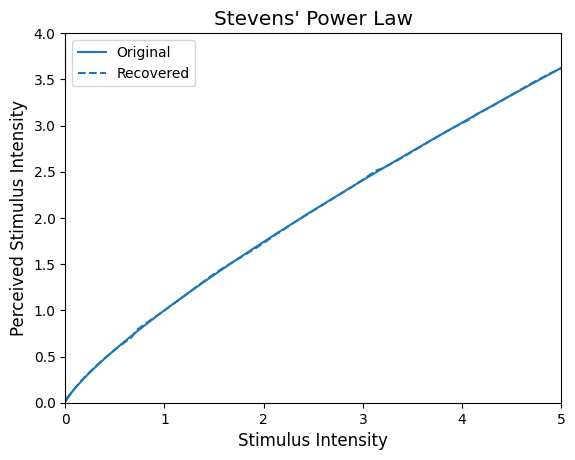

In [120]:
# run benchmark
benchmark(experiment_runner = stevens_power_law(), theorist = dummy_theorist)

#### EXPERIMENT CONDITIONS (X):
      similarity_category_A1  similarity_category_A2  similarity_category_B1  \
0                        0.1                0.100000                     0.1   
1                        0.1                1.514286                     0.1   
2                        0.1                2.928571                     0.1   
3                        0.1                4.342857                     0.1   
4                        0.1                5.757143                     0.1   
...                      ...                     ...                     ...   
4091                    10.0                4.342857                    10.0   
4092                    10.0                5.757143                    10.0   
4093                    10.0                7.171429                    10.0   
4094                    10.0                8.585714                    10.0   
4095                    10.0               10.000000                    10.0   

      s

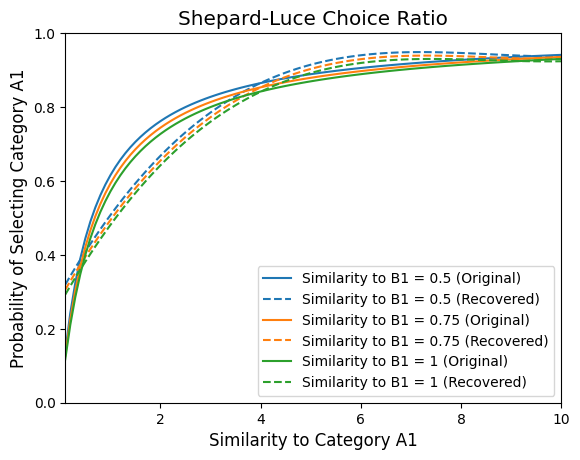

In [121]:
# run benchmark
benchmark(experiment_runner = luce_choice_ratio(), theorist = dummy_theorist)

#### EXPERIMENT CONDITIONS (X):
            S1        S2
0     0.010000  0.010000
1     0.010000  0.060404
2     0.010000  0.110808
3     0.010000  0.161212
4     0.010000  0.211616
...        ...       ...
5045  4.899192  4.949596
5046  4.899192  5.000000
5047  4.949596  4.949596
5048  4.949596  5.000000
5049  5.000000  5.000000

[5050 rows x 2 columns]
#### EXPERIMENT OBSERVATIONS (Y):
      difference_detected
0                0.001850
1                1.796531
2                2.414038
3                2.767704
4                3.057247
...                   ...
5045            -0.003956
5046             0.023082
5047             0.010511
5048             0.024797
5049             0.010142

[5050 rows x 1 columns]
#### IDENTIFIED EQUATION:
Region 1:
y1 = 1.060 + (-11.032) * x0 + (5.415) * x1 + (12.220) * x0^2 + (-1.180) * x0 x1 + (-3.325) * x1^2 + (-4.419) * x0^3 + (0.241) * x0^2 x1 + (0.402) * x0 x1^2 + (0.747) * x1^3

Region 2:
y1 = 0.107 + (-1.244) * x0 + (1.113) * x1 + (0.277) 

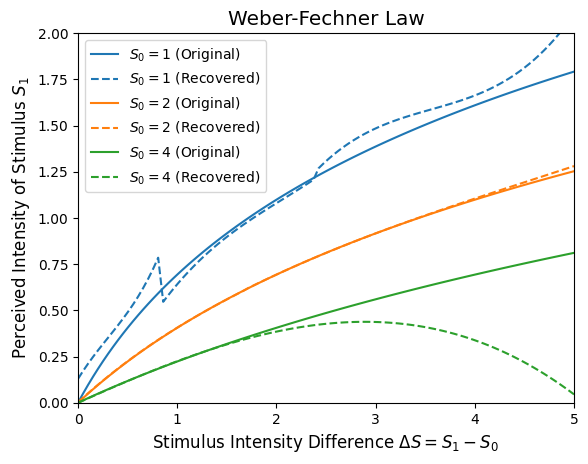

#### EXPERIMENT CONDITIONS (X):
      similarity_category_A1  similarity_category_A2  similarity_category_B1  \
0                        0.1                0.100000                     0.1   
1                        0.1                1.514286                     0.1   
2                        0.1                2.928571                     0.1   
3                        0.1                4.342857                     0.1   
4                        0.1                5.757143                     0.1   
...                      ...                     ...                     ...   
4091                    10.0                4.342857                    10.0   
4092                    10.0                5.757143                    10.0   
4093                    10.0                7.171429                    10.0   
4094                    10.0                8.585714                    10.0   
4095                    10.0               10.000000                    10.0   

      s

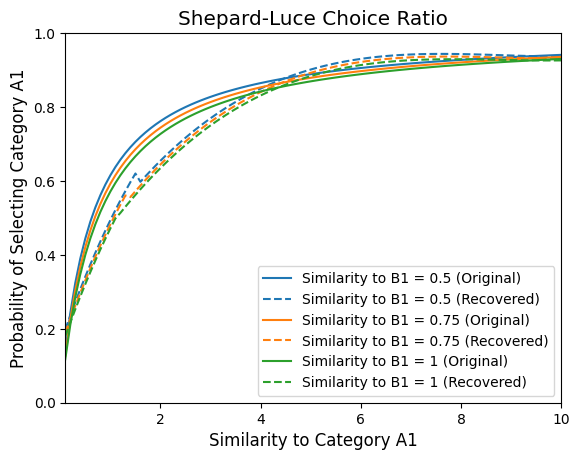

#### EXPERIMENT CONDITIONS (X):
           S
0   0.010000
1   0.060404
2   0.110808
3   0.161212
4   0.211616
..       ...
95  4.798384
96  4.848788
97  4.899192
98  4.949596
99  5.000000

[100 rows x 1 columns]
#### EXPERIMENT OBSERVATIONS (Y):
    perceived_intensity
0              0.026141
1              0.090723
2              0.173002
3              0.236749
4              0.278760
..                  ...
95             3.508346
96             3.536885
97             3.572911
98             3.596460
99             3.618646

[100 rows x 1 columns]
#### IDENTIFIED EQUATION:
Region 1:
y1 = 4.904 + (-4.850) * x0 + (2.248) * x0^2 + (-0.304) * x0^3

Region 2:
y1 = -0.573 + (1.398) * x0 + (-0.170) * x0^2 + (0.012) * x0^3

Region 3:
y1 = 0.611 + (-0.575) * x0 + (1.478) * x0^2 + (-0.517) * x0^3

Region 4:
y1 = -19.466 + (14.501) * x0 + (-3.196) * x0^2 + (0.244) * x0^3

Region 5:
y1 = 0.013 + (1.410) * x0 + (-0.669) * x0^2 + (0.118) * x0^3

Region 6:
y1 = 3.128 + (-4.641) * x0 + (3.353) * x

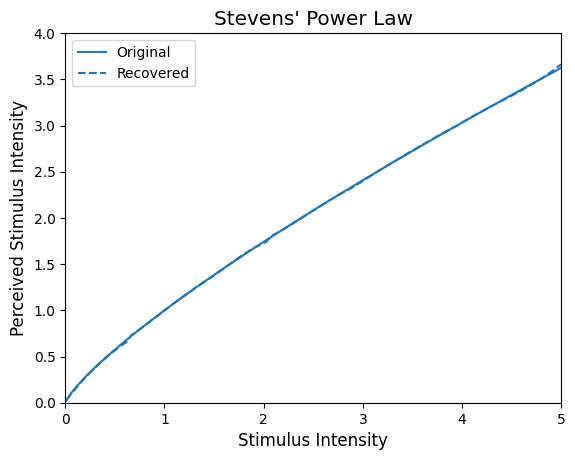

#### EXPERIMENT CONDITIONS (X):
      P_asymptotic  trial
0              0.0    1.0
1              0.0    2.0
2              0.0    3.0
3              0.0    4.0
4              0.0    5.0
...            ...    ...
9995           0.5   96.0
9996           0.5   97.0
9997           0.5   98.0
9998           0.5   99.0
9999           0.5  100.0

[10000 rows x 2 columns]
#### EXPERIMENT OBSERVATIONS (Y):
      performance
0        0.000357
1        0.067477
2        0.080345
3        0.113142
4        0.144219
...           ...
9995     0.982963
9996     0.981065
9997     0.966602
9998     0.989876
9999     0.965907

[10000 rows x 1 columns]
#### IDENTIFIED EQUATION:
Region 1:
y1 = 7.339 + (-0.655) * x0 + (-0.210) * x1 + (-0.159) * x0^2 + (0.018) * x0 x1 + (0.002) * x1^2 + (0.073) * x0^3 + (0.001) * x0^2 x1 + (-0.000) * x0 x1^2 + (-0.000) * x1^3

Region 2:
y1 = 0.129 + (0.895) * x0 + (0.019) * x1 + (0.111) * x0^2 + (-0.022) * x0 x1 + (-0.000) * x1^2 + (-0.076) * x0^3 + (-0.001) * x0^2 x1 +

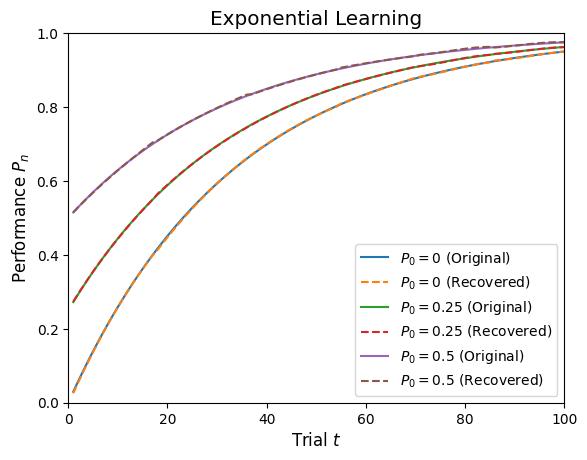

#### EXPERIMENT CONDITIONS (X):
      V_A       P_A  V_B  P_B
0    -1.0  0.000000 -1.0  0.0
1    -1.0  0.111111 -1.0  0.0
2    -1.0  0.222222 -1.0  0.0
3    -1.0  0.333333 -1.0  0.0
4    -1.0  0.444444 -1.0  0.0
...   ...       ...  ...  ...
9995  1.0  0.555556  1.0  1.0
9996  1.0  0.666667  1.0  1.0
9997  1.0  0.777778  1.0  1.0
9998  1.0  0.888889  1.0  1.0
9999  1.0  1.000000  1.0  1.0

[10000 rows x 4 columns]
#### EXPERIMENT OBSERVATIONS (Y):
      choose_A
0     0.509911
1     0.015994
2     0.002285
3     0.000410
4     0.000077
...        ...
9995  0.004010
9996  0.008400
9997  0.013533
9998  0.044395
9999  0.530886

[10000 rows x 1 columns]
#### IDENTIFIED EQUATION:
Region 1:
y1 = 0.700 + (0.245) * x0 + (1.407) * x1 + (-1.055) * x2 + (-1.539) * x3 + (-0.227) * x0^2 + (1.456) * x0 x1 + (0.444) * x0 x2 + (0.427) * x0 x3 + (-2.648) * x1^2 + (-0.248) * x1 x2 + (0.316) * x1 x3 + (1.044) * x2^2 + (-1.900) * x2 x3 + (2.886) * x3^2 + (-0.160) * x0^3 + (-0.719) * x0^2 x1 + (0.439) * x0

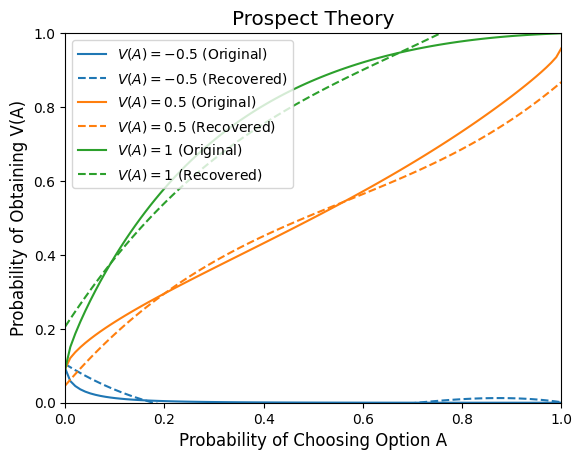

#### EXPERIMENT CONDITIONS (X):
      cur_task_strength  alt_task_strength  is_switch
0                  0.02               0.02        0.0
1                  0.02               0.04        0.0
2                  0.02               0.06        0.0
3                  0.02               0.08        0.0
4                  0.02               0.10        0.0
...                 ...                ...        ...
4995               1.00               0.92        1.0
4996               1.00               0.94        1.0
4997               1.00               0.96        1.0
4998               1.00               0.98        1.0
4999               1.00               1.00        1.0

[5000 rows x 3 columns]
#### EXPERIMENT OBSERVATIONS (Y):
      cur_task_performance
0                 0.921102
1                 0.905178
2                 0.889136
3                 0.863120
4                 0.859739
...                    ...
4995              0.537979
4996              0.530767
4997              

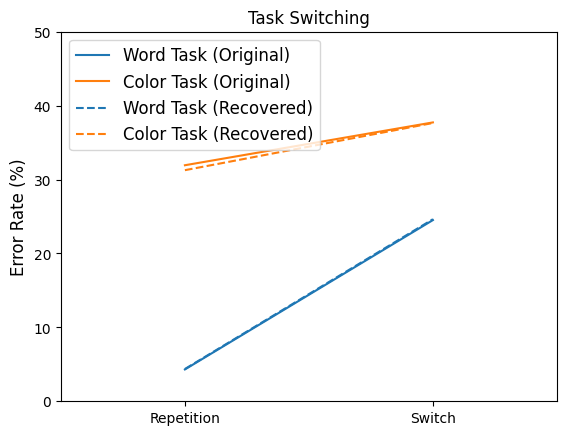

In [141]:
# run benchmark
experiment_runners = [weber_fechner_law, luce_choice_ratio, stevens_power_law, exp_learning, prospect_theory, task_switching]
for experiment in experiment_runners:
    benchmark(experiment_runner = experiment(), theorist = dummy_theorist)


#### EXPERIMENT CONDITIONS (X):
            S1        S2
0     0.010000  0.010000
1     0.010000  0.060404
2     0.010000  0.110808
3     0.010000  0.161212
4     0.010000  0.211616
...        ...       ...
5045  4.899192  4.949596
5046  4.899192  5.000000
5047  4.949596  4.949596
5048  4.949596  5.000000
5049  5.000000  5.000000

[5050 rows x 2 columns]
#### EXPERIMENT OBSERVATIONS (Y):
      difference_detected
0                0.009647
1                1.781592
2                2.391749
3                2.785746
4                3.043794
...                   ...
5045            -0.000731
5046             0.027404
5047            -0.013397
5048             0.008177
5049            -0.015740

[5050 rows x 1 columns]
#### IDENTIFIED EQUATION:
y1 = 1.041 + (-3.900) * S1 + (1.967) * S2 + (1.353) * S1^2 + (0.044) * S1 S2 + (-0.489) * S2^2 + (-0.159) * S1^3 + (-0.003) * S1^2 S2 + (-0.004) * S1 S2^2 + (0.045) * S2^3
None
#### VALIDATION SET MSE:
difference_detected    0.11908
dtype: float6

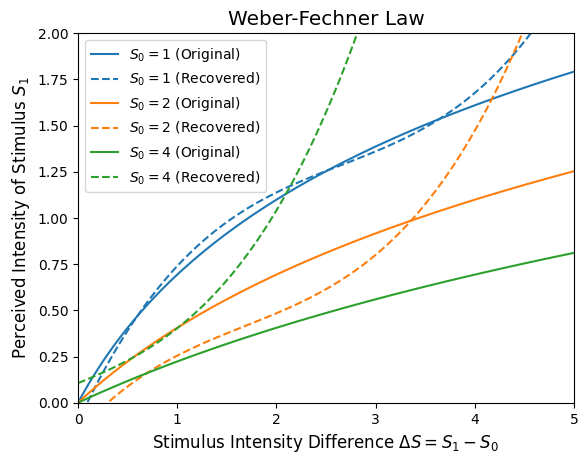

#### EXPERIMENT CONDITIONS (X):
      similarity_category_A1  similarity_category_A2  similarity_category_B1  \
0                        0.1                0.100000                     0.1   
1                        0.1                1.514286                     0.1   
2                        0.1                2.928571                     0.1   
3                        0.1                4.342857                     0.1   
4                        0.1                5.757143                     0.1   
...                      ...                     ...                     ...   
4091                    10.0                4.342857                    10.0   
4092                    10.0                5.757143                    10.0   
4093                    10.0                7.171429                    10.0   
4094                    10.0                8.585714                    10.0   
4095                    10.0               10.000000                    10.0   

      s

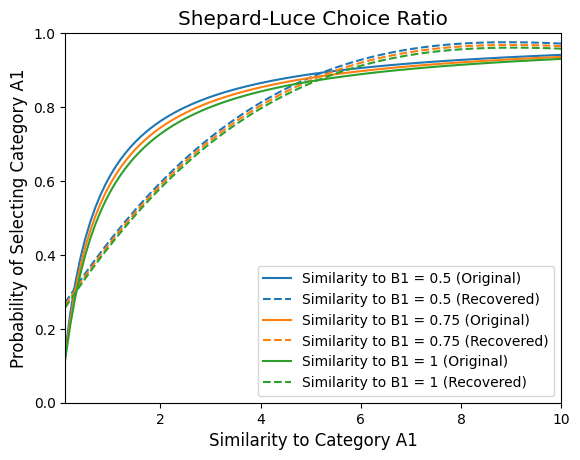

#### EXPERIMENT CONDITIONS (X):
           S
0   0.010000
1   0.060404
2   0.110808
3   0.161212
4   0.211616
..       ...
95  4.798384
96  4.848788
97  4.899192
98  4.949596
99  5.000000

[100 rows x 1 columns]
#### EXPERIMENT OBSERVATIONS (Y):
    perceived_intensity
0              0.034017
1              0.128522
2              0.190448
3              0.229270
4              0.275174
..                  ...
95             3.500315
96             3.539519
97             3.551877
98             3.598759
99             3.628217

[100 rows x 1 columns]
#### IDENTIFIED EQUATION:
y1 = 0.102 + (0.972) * S + (-0.089) * S^2 + (0.007) * S^3
None
#### VALIDATION SET MSE:
perceived_intensity    0.000416
dtype: float64


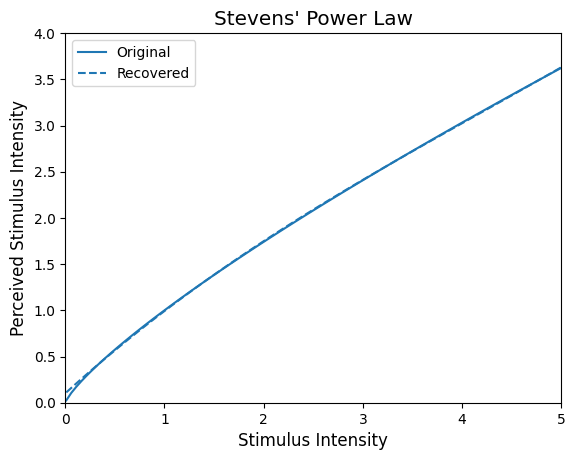

#### EXPERIMENT CONDITIONS (X):
      P_asymptotic  trial
0              0.0    1.0
1              0.0    2.0
2              0.0    3.0
3              0.0    4.0
4              0.0    5.0
...            ...    ...
9995           0.5   96.0
9996           0.5   97.0
9997           0.5   98.0
9998           0.5   99.0
9999           0.5  100.0

[10000 rows x 2 columns]
#### EXPERIMENT OBSERVATIONS (Y):
      performance
0        0.022294
1        0.045012
2        0.086588
3        0.103762
4        0.151485
...           ...
9995     0.961560
9996     0.977242
9997     0.968508
9998     0.987282
9999     0.972282

[10000 rows x 1 columns]
#### IDENTIFIED EQUATION:
y1 = 0.029 + (0.934) * P_asymptotic + (0.025) * trial + (-0.021) * P_asymptotic^2 + (-0.020) * P_asymptotic trial + (-0.000) * trial^2 + (0.002) * P_asymptotic^3 + (0.000) * P_asymptotic^2 trial + (0.000) * P_asymptotic trial^2 + (0.000) * trial^3
None
#### VALIDATION SET MSE:
performance    0.000113
dtype: float64


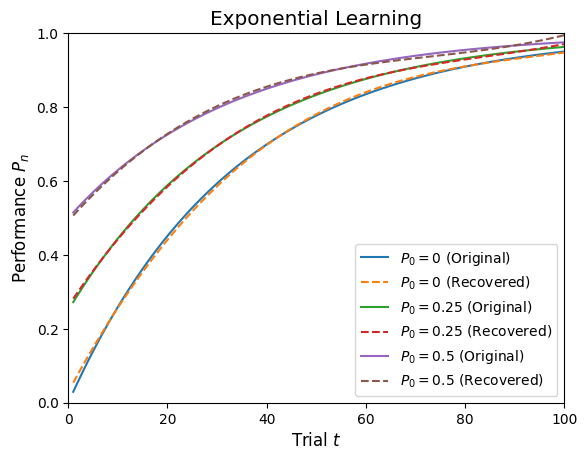

#### EXPERIMENT CONDITIONS (X):
      V_A       P_A  V_B  P_B
0    -1.0  0.000000 -1.0  0.0
1    -1.0  0.111111 -1.0  0.0
2    -1.0  0.222222 -1.0  0.0
3    -1.0  0.333333 -1.0  0.0
4    -1.0  0.444444 -1.0  0.0
...   ...       ...  ...  ...
9995  1.0  0.555556  1.0  1.0
9996  1.0  0.666667  1.0  1.0
9997  1.0  0.777778  1.0  1.0
9998  1.0  0.888889  1.0  1.0
9999  1.0  1.000000  1.0  1.0

[10000 rows x 4 columns]
#### EXPERIMENT OBSERVATIONS (Y):
      choose_A
0     0.503484
1     0.014874
2     0.001895
3     0.000484
4     0.000099
...        ...
9995  0.003660
9996  0.007983
9997  0.019523
9998  0.044444
9999  0.554286

[10000 rows x 1 columns]
#### IDENTIFIED EQUATION:
y1 = 0.489 + (0.487) * V_A + (-0.231) * P_A + (-0.478) * V_B + (0.306) * P_B + (0.002) * V_A^2 + (0.980) * V_A P_A + (0.001) * V_A V_B + (-0.307) * V_A P_B + (0.302) * P_A^2 + (0.262) * P_A V_B + (-0.069) * P_A P_B + (-0.002) * V_B^2 + (-1.031) * V_B P_B + (-0.373) * P_B^2 + (-0.202) * V_A^3 + (0.017) * V_A^2 P_A +

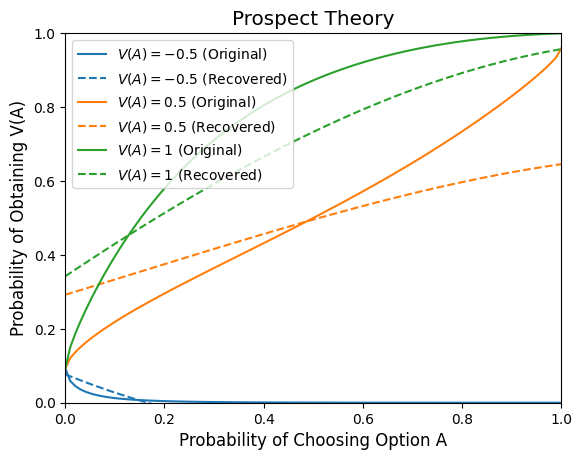

#### EXPERIMENT CONDITIONS (X):
      cur_task_strength  alt_task_strength  is_switch
0                  0.02               0.02        0.0
1                  0.02               0.04        0.0
2                  0.02               0.06        0.0
3                  0.02               0.08        0.0
4                  0.02               0.10        0.0
...                 ...                ...        ...
4995               1.00               0.92        1.0
4996               1.00               0.94        1.0
4997               1.00               0.96        1.0
4998               1.00               0.98        1.0
4999               1.00               1.00        1.0

[5000 rows x 3 columns]
#### EXPERIMENT OBSERVATIONS (Y):
      cur_task_performance
0                 0.923208
1                 0.900460
2                 0.890033
3                 0.891330
4                 0.861322
...                    ...
4995              0.535386
4996              0.530458
4997              

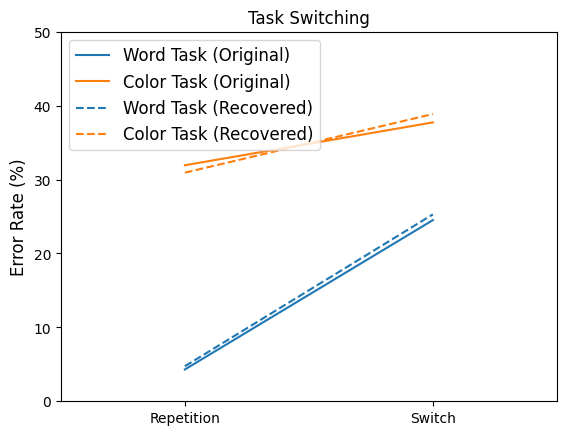

In [142]:
# run benchmark
experiment_runners = [weber_fechner_law, luce_choice_ratio, stevens_power_law, exp_learning, prospect_theory, task_switching]
for experiment in experiment_runners:
    benchmark(experiment_runner = experiment(), theorist = PolynomialRegressor())


### Weber-Fechner-Law

The Weber-Fechner law quantifies the minimum change in a stimulus required to be noticeable. Similar to Steven's power law, the greater the intensity of a stimulus, the larger the change needed to be perceivable. This relationship is hypothesized to be proportional to the logarithm of the ratio between the two stimuli:

$\text{perceived intensity} = \log\left(\dfrac{S_1}{S_2}\right)$


where $S_1$ ($range: [0.01, 5.00]$) is the intensity of a physical stimulus (e.g., the luminosity of a lamp), $S_2$ ($range: [0.01, 5.00]$ ) is a reference stimulus (e.g., the luminosity of a background light), and $y$ is the perceived stimulus intensity (e.g. the perception of the lamp's luminosity).

#### EXPERIMENT CONDITIONS (X):
            S1        S2
0     0.010000  0.010000
1     0.010000  0.060404
2     0.010000  0.110808
3     0.010000  0.161212
4     0.010000  0.211616
...        ...       ...
5045  4.899192  4.949596
5046  4.899192  5.000000
5047  4.949596  4.949596
5048  4.949596  5.000000
5049  5.000000  5.000000

[5050 rows x 2 columns]
#### EXPERIMENT OBSERVATIONS (Y):
      difference_detected
0                0.003799
1                1.795133
2                2.401268
3                2.794204
4                3.078147
...                   ...
5045             0.006688
5046             0.023645
5047             0.005411
5048             0.011124
5049             0.006660

[5050 rows x 1 columns]
#### IDENTIFIED EQUATION:
Region 1:
y1 = -0.643 + (-9.214) * x0 + (4.111) * x1 + (14.513) * x0^2 + (-2.149) * x0 x1 + (-0.977) * x1^2 + (-6.542) * x0^3 + (0.418) * x0^2 x1 + (0.297) * x0 x1^2 + (0.078) * x1^3

Region 2:
y1 = -0.706 + (-0.728) * x0 + (1.208) * x1 + (0.108)

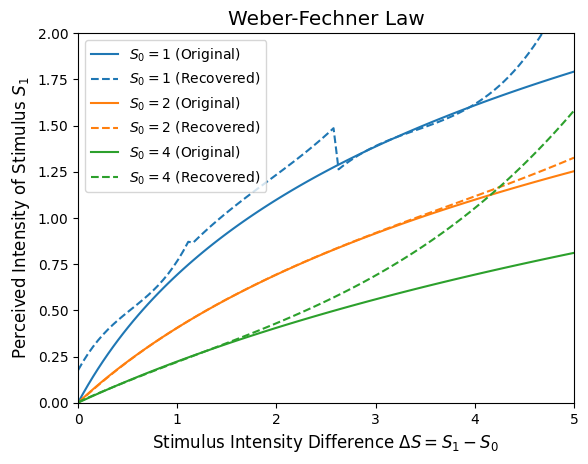

In [122]:
# run benchmark
benchmark(experiment_runner = weber_fechner_law(), theorist = dummy_theorist)

### Expected Utility Model with Two Choice Options

The expected utility model evaluates decision-making under uncertainty, quantifying the expected value of different choices based on their potential outcomes and associated probabilities. The model assumes that individuals aim to maximize their expected utility when faced with two options. Each option has a specific value and probability, influenced by a certain level of noise.

For two choice options, the expected value of each option is calculated as follows:

$$
E_A = V_A \times P_A
$$

$$
E_B = V_B \times P_B
$$

where:
- $V_A$ and $V_B$ represent the values of options A and B respectively.
- $P_A$ and $P_B$ represent the probabilities associated with these options.

The probability of choosing option A $P_{\text{choose}_A}$ is then determined using the softmax function, which considers the expected values of both options and a choice temperature parameter that influences the sensitivity to differences in expected values:

$$
P_{\text{choose}_A} = \frac{\exp(E_A / \beta)}{\exp(E_A / \beta) + \exp(E_B / \beta)}
$$

In this model:
- $\beta$ controls the degree of randomness in the choice, with higher values leading to more exploration and lower values leading to more deterministic choices based on the expected values.
- The softmax function ensures that the probabilities sum to 1, providing a normalized measure of the likelihood of choosing each option.

This model captures the influence of value, probability, and noise on decision-making, reflecting the complexity and variability of human choices under uncertainty.



In [135]:
# run benchmark
benchmark(experiment_runner = expected_value_theory(), theorist = dummy_theorist)

#### EXPERIMENT CONDITIONS (X):
        V_A       P_A       V_B       P_B
0 -1.000000 -0.777778 -0.555556 -0.333333
1 -0.111111  0.111111  0.333333  0.555556
2  0.777778  1.000000  0.000000  0.111111
3  0.222222  0.333333  0.444444  0.555556
4  0.666667  0.777778  0.888889  1.000000
5 -1.000000 -0.777778 -0.555556 -0.333333
6 -0.111111  0.111111  0.333333  0.555556
7  0.777778  1.000000  0.000000  0.111111
8  0.222222  0.333333  0.444444  0.555556
9  0.666667  0.777778  0.888889  1.000000
#### EXPERIMENT OBSERVATIONS (Y):
   choose_A
0  0.956823
1  0.228097
2  0.986951
3  0.327354
4  0.152737
5  0.946470
6  0.257393
7  0.979081
8  0.300309
9  0.145128


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


ValueError: Found array with 0 sample(s) (shape=(0, 4)) while a minimum of 1 is required by PolynomialFeatures.